In [1]:
# load libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob 
import os
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, FactorAnalysis

# see process_data.py
import process_data as data

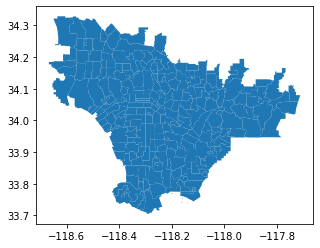

In [2]:
# load processed zipcodes (see r files)
zipcodes_shp = os.path.join("..", "processed", "collapsed_measures", "zipcodes_processed.shp") 
zipcodes = gpd.read_file(zipcodes_shp) 

zipcodes.plot()
plt.show()

In [3]:
# create dict (to be converted to df) to store final data 
processed_data = dict() 

In [4]:
# map data of interest to csv info (Data object from process_data module)
data_path = os.path.join("..", "data", "pca")

csvs_mapped = dict(
    foreign_born = data.Data(
        path=os.path.join(data_path, "ACSDP5Y2022.DP02-Data.csv"), 
        cols_to_extract=dict(
            DP02_0094PE = "ForeignBorn"
        ),
        cols_to_merge=None
    ),
    employment_poverty = data.Data(
        path=os.path.join(data_path, "ACSDP5Y2022.DP03-Data.csv"), 
        cols_to_extract=dict(
            DP03_0005E = "Unemployment" 
        ),
        cols_to_merge=dict(
            WorkOutdoors = ["DP03_0030E", "DP03_0031E"] # natural resources, construction, maintenance, production, transportation, material moving
        )
    ),
    population_ages = data.Data(
        path=os.path.join(data_path, "ACSDP5Y2022.DP05-Data.csv"), 
        cols_to_extract=dict(
            DP05_0001E = "TotalPop",
            DP05_0066M = "WhitePop",
            DP05_0067E = "BlackPop", 
            DP05_0069E = "AsianPop", # doesn't include native hawaiians and pacific islanders (ask abt it?)
            DP05_0068E = "NativePop", 
            DP05_0072PE = "HispanicLatino", 
            DP05_0024E = "Elderly", # 65 and over
            DP05_0019E = "Children" # under 18 
        ), 
        cols_to_merge=None
    ), 
    renting = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S1101-Data.csv"), 
        cols_to_extract=dict(
            S1101_C01_019E = "Renting",
            S1101_C01_013E = "LiveAlone",
            S1101_C01_014E = "LiveAloneElderly" # live alone and >= 65 yrs old
        ), 
        cols_to_merge=None
    ), 
    education = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S1501-Data.csv"),
        cols_to_extract=None,
        cols_to_merge=dict(
            LessThanHS = ["S1501_C01_002E", "S1501_C01_007E", "S1501_C01_008E"], # among those > 18
            MaxHS = ["S1501_C01_003E", "S1501_C01_009E"] # among those > 18
        )
    ), 
    poverty = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S1701-Data.csv"),
        cols_to_extract=dict(
            S1701_C01_038E = "ExtremePoverty" # income is below 50% of poverty level
        ),
        cols_to_merge=None
    ),
    living_conditions = data.Data(
        path=os.path.join(data_path, "ACSST5Y2022.S2501-Data.csv"),
        cols_to_extract=None,
        cols_to_merge=dict(
            ManyOccupants = ["S2501_C01_003E", "S2501_C01_004E", "S2501_C01_005E"],
            Overcrowded = ["S2501_C01_007E", "S2501_C01_008E"] # defined as > 1.01 ppl/room: https://www.hcd.ca.gov/planning-and-community-development/housing-elements/building-blocks/overpayment-payment-and-overcrowding
        )
    )
)

# make another mapping for outlier stuff? or process outliers above to make them match others...todo

    ZIPCODE                                           geometry
0     90001  POLYGON ((-118.2433805350907 33.98923611416206...
1     90002  POLYGON ((-118.2343068083092 33.96100991986967...
2     90003  POLYGON ((-118.28284781820747 33.9759665503730...
3     90004  POLYGON ((-118.28410404339357 34.0834877835880...
4     90005  MULTIPOLYGON (((-118.33541159329886 34.0617852...
..      ...                                                ...
245   91790  POLYGON ((-117.94084662927371 34.0924822704164...
246   91791  POLYGON ((-117.91660458093571 34.0864522008898...
247   91792  POLYGON ((-117.89060799539024 34.0085798344635...
248   91801  POLYGON ((-118.1347230015482 34.08511986984669...
249   91803  POLYGON ((-118.15468673975664 34.0904168481301...

[250 rows x 2 columns]


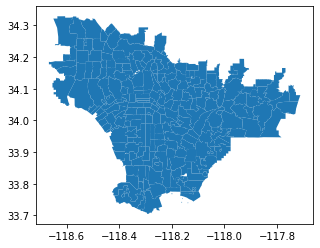

In [5]:
# open up any csv, to filter zipcodes
ex_csv = csvs_mapped["population_ages"]
ex_df = ex_csv.data_read_csv().drop([0]) # remove row with col name description
ex_df.reset_index(drop=True, inplace=True)

# get rows of relevant zipcodes
pattern = '|'.join(zipcodes["ZIPCODE"]) # regex of all zipcode ids; | = or
select_zipcodes = ex_df[ex_df["NAME"].str.contains(pattern)]

# in NAME col, remove "ZCTA5"
# select_zipcodes["NAME"] = select_zipcodes["NAME"].str.replace("ZCTA5 ", '')
select_zipcodes.loc[:, "NAME"] = select_zipcodes.loc[:, "NAME"].str.replace("ZCTA5 ", '')

# use selected zipcodes going forward 
zipcodes_to_keep = list(select_zipcodes["NAME"])
filtered_zipcodes = zipcodes[zipcodes.loc[:, "ZIPCODE"].isin(zipcodes_to_keep)]
processed_data["ZIPCODE"] = list(filtered_zipcodes["ZIPCODE"])
processed_data["geometry"] = list(filtered_zipcodes["geometry"])

print(pd.DataFrame(processed_data))
filtered_zipcodes.plot()
plt.show()


In [6]:
# main; store relevant data in processed_data dict
for data in csvs_mapped: 
    data_obj = csvs_mapped[data]
    csv_df = data_obj.data_read_csv().drop([0])
    csv_df.reset_index(drop=True, inplace=True)

    # get rows of relevant zipcodes
    pattern = '|'.join(filtered_zipcodes["ZIPCODE"]) # regex of all zipcode ids; | = or
    filtered = csv_df[csv_df.loc[:, "NAME"].str.contains(pattern)]
    
    # extract cols and add to larger dict
    extracted_cols = data_obj.data_extract_cols(filtered)
    if (not extracted_cols.empty):
        processed_data.update(extracted_cols.to_dict(orient="list"))

    # merge columns together, add to larger dict
    merged_cols = data_obj.data_merge_cols(filtered)
    if (not merged_cols.empty):
        processed_data.update(merged_cols.to_dict(orient="list"))

In [7]:
# convert compiled data to df
processed_data_df = pd.DataFrame.from_dict(processed_data)
# move geometry col to very end, and totalpop to front
processed_data_df.insert(len(processed_data_df.columns) - 1, "geometry", processed_data_df.pop("geometry"))
processed_data_df.insert(1, "TotalPop", processed_data_df.pop("TotalPop"))

print(processed_data_df.columns)
print(str(processed_data_df))

Index(['ZIPCODE', 'TotalPop', 'ForeignBorn', 'Unemployment', 'WorkOutdoors',
       'WhitePop', 'BlackPop', 'AsianPop', 'NativePop', 'HispanicLatino',
       'Elderly', 'Children', 'Renting', 'LiveAlone', 'LiveAloneElderly',
       'LessThanHS', 'MaxHS', 'ExtremePoverty', 'ManyOccupants', 'Overcrowded',
       'geometry'],
      dtype='object')
    ZIPCODE TotalPop ForeignBorn Unemployment  WorkOutdoors WhitePop BlackPop  \
0     90001    57652        40.9         2676         10628     2238     4825   
1     90002    53108        34.7         2793          8441     2379     8925   
2     90003    75024        39.8         3133         12442     2734    13359   
3     90004    58833        46.5         2534          5217     1776     3553   
4     90005    37754        54.1         1034          3469     1538     2545   
..      ...      ...         ...          ...           ...      ...      ...   
245   91790    44855        31.4         1486          5006     1515     1629   
246  

In [8]:
# todo convert everything to percentages....

In [9]:
keep = processed_data_df[["ZIPCODE", "TotalPop", "geometry"]]
pca_df = processed_data_df.drop(columns=["ZIPCODE", "TotalPop", "geometry"])
pca_df.columns 

Index(['ForeignBorn', 'Unemployment', 'WorkOutdoors', 'WhitePop', 'BlackPop',
       'AsianPop', 'NativePop', 'HispanicLatino', 'Elderly', 'Children',
       'Renting', 'LiveAlone', 'LiveAloneElderly', 'LessThanHS', 'MaxHS',
       'ExtremePoverty', 'ManyOccupants', 'Overcrowded'],
      dtype='object')

In [10]:
print(pca_df.shape)
print(pca_df.describe(include="all")) # aka cols need to be converted to numeric

(250, 18)
       ForeignBorn Unemployment  WorkOutdoors WhitePop BlackPop AsianPop  \
count          250          250    250.000000      250      250      250   
unique         189          235           NaN      232      234      244   
top              -            0           NaN       13        0        0   
freq             4            8           NaN        4        8        6   
mean           NaN          NaN   3632.752000      NaN      NaN      NaN   
std            NaN          NaN   3603.766637      NaN      NaN      NaN   
min            NaN          NaN      0.000000      NaN      NaN      NaN   
25%            NaN          NaN   1121.000000      NaN      NaN      NaN   
50%            NaN          NaN   2452.500000      NaN      NaN      NaN   
75%            NaN          NaN   5054.750000      NaN      NaN      NaN   
max            NaN          NaN  19042.000000      NaN      NaN      NaN   

       NativePop HispanicLatino Elderly Children Renting LiveAlone  \
count  

In [11]:
numeric_df = pd.DataFrame()
for i in pca_df.columns:
    numeric_df[i] = pd.to_numeric(pca_df[i], errors="coerce") # convert strs ("-") into nan

print(numeric_df.shape)
print(numeric_df.describe(include="all"))


(250, 18)
       ForeignBorn  Unemployment  WorkOutdoors     WhitePop      BlackPop  \
count   246.000000    250.000000    250.000000   250.000000    250.000000   
mean     33.261789   1309.396000   3632.752000  1415.508000   3239.340000   
std      11.929199    908.303175   3603.766637   605.681118   4800.532052   
min       0.000000      0.000000      0.000000    13.000000      0.000000   
25%      24.750000    711.250000   1121.000000  1035.500000    710.250000   
50%      33.200000   1105.000000   2452.500000  1447.000000   1708.500000   
75%      40.975000   1801.000000   5054.750000  1834.750000   3558.250000   
max      88.700000   5419.000000  19042.000000  3000.000000  32619.000000   

           AsianPop    NativePop  HispanicLatino       Elderly     Children  \
count    250.000000   250.000000      250.000000    250.000000    250.00000   
mean    6355.564000   844.100000    35152.220000   5018.920000   7293.10800   
std     6745.376965   789.261753    21302.194321   2747.602

In [12]:
# mask nas with col's mean to preserve data shape: https://medium.com/writing-data/basic-data-cleaning-removing-nans-1787110fc11b
masked_df = numeric_df.fillna(numeric_df.mean(axis=0))
print(masked_df.shape)
print(masked_df.describe(include="all"))
# mean, std are all p much the same yay

(250, 18)
       ForeignBorn  Unemployment  WorkOutdoors     WhitePop      BlackPop  \
count   250.000000    250.000000    250.000000   250.000000    250.000000   
mean     33.261789   1309.396000   3632.752000  1415.508000   3239.340000   
std      11.832995    908.303175   3603.766637   605.681118   4800.532052   
min       0.000000      0.000000      0.000000    13.000000      0.000000   
25%      25.225000    711.250000   1121.000000  1035.500000    710.250000   
50%      33.261789   1105.000000   2452.500000  1447.000000   1708.500000   
75%      40.875000   1801.000000   5054.750000  1834.750000   3558.250000   
max      88.700000   5419.000000  19042.000000  3000.000000  32619.000000   

           AsianPop    NativePop  HispanicLatino       Elderly     Children  \
count    250.000000   250.000000      250.000000    250.000000    250.00000   
mean    6355.564000   844.100000    35152.220000   5018.920000   7293.10800   
std     6745.376965   789.261753    21302.194321   2747.602

In [13]:
scaled = pd.DataFrame()
for i in masked_df.columns:
    scaled[i] = scale(masked_df[i]) 

x = scaled.values
print(np.isnan(x).any())
print(scaled)

False
     ForeignBorn  Unemployment  WorkOutdoors  WhitePop  BlackPop  AsianPop  \
0       0.646796      1.507586      1.944987  1.360686  0.330972 -0.869530   
1       0.121786      1.636656      1.336905  1.593949  1.186757 -0.814716   
2       0.553649      2.011732      2.449359  2.181242  2.112258 -0.865222   
3       1.120998      1.350937      0.440491  0.596378  0.065470  1.353032   
4       1.764559     -0.303807     -0.045530  0.202644 -0.144928  0.957005   
..           ...           ...           ...       ...       ...       ...   
245    -0.157654      0.194823      0.381823  0.164594 -0.336123  0.597967   
246     0.231869      0.226815     -0.089739 -0.169584 -0.370146  0.619209   
247     0.807686     -0.464868     -0.220698 -0.770111 -0.071039  1.076883   
248     1.078659      0.414352      0.112677 -0.508725 -0.280602  3.380699   
249     1.146402     -0.650200     -0.381686 -0.963670 -0.502688  1.239393   

     NativePop  HispanicLatino   Elderly  Children   Rent

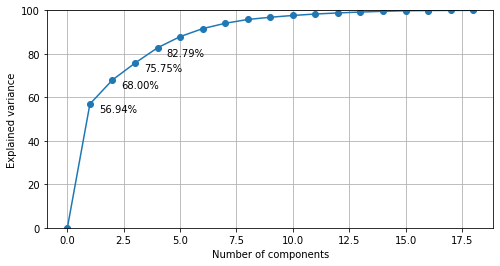

In [14]:
# run on all vars
pca_full = PCA(n_components=len(scaled.columns))
pca_full.fit(x)

explained_variance = np.cumsum(pca_full.explained_variance_ratio_ * 100) # ratio = eigenval / sum(eigenvals)
# Create an array with a zero at the beginning
explained_variance = np.concatenate([[0], explained_variance])

plt.figure(figsize=(8, 4))
plt.plot(explained_variance, marker='o')
# Add big black markers at each point
plt.scatter(range(len(explained_variance)), explained_variance, s=10, color='black')

plt.ylim(0,100)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid()

# Add text annotations for explained variance numbers
for i, var in enumerate(explained_variance[1:5]):
    plt.text(i+1.4, var, f'{var:.2f}%', fontsize=10, ha='left', va='top')

plt.show()

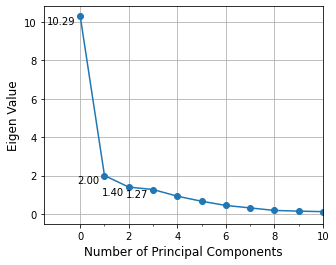

In [15]:
# plot eigenvals
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)

# Plot the explained variance
plt.plot(pca_full.explained_variance_, marker='o')

# # Add big black markers at each point
# plt.scatter(range(len(pca_full.explained_variance_)), pca_full.explained_variance_, s=10, color='black', label='Markers')

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Eigen Value', fontsize=12)

# Add text annotations for explained variance numbers
for i, var in enumerate(pca_full.explained_variance_[:4]):
    plt.text(i-.2, var, f'{var:.2f}', fontsize=10, ha='right', va='top')
ax.set_xticks(np.arange(0, 23, 1), minor=True)
plt.xlim(-1.5,10)
plt.grid()
plt.show()
# use first three pcs!

In [16]:
pca_3 = PCA(n_components = 3) # select 3 components
PC3 = pca_3.fit_transform(x) # we apply the PCA to x, this returns the an array of scores (og data projected onto new basis)

print('Number of components:', pca_3.n_components_)
print('Number of features:', pca_3.n_features_in_) # aka number cols 
print('Number of samples:', pca_3.n_samples_) # aka number of rows 

Number of components: 3
Number of features: 18
Number of samples: 250


In [17]:
scores = pd.DataFrame(data = PC3, columns = ['PC1','PC2','PC3']) 
scores.head().style.format(precision=2)
print(scores)

          PC1       PC2       PC3
0    4.587758  1.274060  0.674626
1    4.298106  1.372811 -0.475797
2    7.111192  2.365646 -0.369276
3    3.629253  0.936008  1.360318
4    0.983429  1.611930  2.144050
..        ...       ...       ...
245  1.319109 -1.638359 -0.038011
246 -0.075344 -1.501905 -0.044415
247 -0.685830 -1.439755  0.986228
248  2.061580 -2.197378  1.422558
249 -0.920919 -1.158874  1.520835

[250 rows x 3 columns]


In [60]:
# get componenets matrix
components = pd.DataFrame(data = pca_3.components_.T, columns = ['PC1','PC2','PC3'], index = scaled.columns)
print(components)

                       PC1       PC2       PC3
ForeignBorn       0.098331  0.002578  0.661260
Unemployment      0.283586  0.128704 -0.086419
WorkOutdoors      0.293238  0.052557  0.037906
WhitePop          0.249195  0.006498 -0.155402
BlackPop          0.136654  0.210835 -0.422586
AsianPop          0.088532 -0.446740  0.222800
NativePop         0.246076 -0.012993 -0.038873
HispanicLatino    0.304903 -0.061902 -0.081803
Elderly           0.241545 -0.316858 -0.104968
Children          0.300036 -0.036749 -0.086754
Renting           0.026262  0.557336  0.342125
LiveAlone        -0.131250  0.410179 -0.181841
LiveAloneElderly -0.111746  0.093105 -0.273924
LessThanHS        0.282737  0.142471  0.116096
MaxHS             0.299525 -0.044594 -0.005291
ExtremePoverty    0.268574  0.249637  0.006989
ManyOccupants     0.290062 -0.123135 -0.102883
Overcrowded       0.277669  0.208661  0.159448


In [73]:
# get variance, aka eigenval, of each pc
eig = scores.var()
print(eig) 

PC1    10.289817
PC2     1.999434
PC3     1.400077
dtype: float64


In [63]:
loadings = components.mul(np.sqrt(pca_3.explained_variance_))
print(loadings)

# each column entry = weight of the og variable in contributing to pc


                       PC1       PC2       PC3
ForeignBorn       0.315422  0.003646  0.782435
Unemployment      0.909679  0.181990 -0.102255
WorkOutdoors      0.940641  0.074317  0.044852
WhitePop          0.799361  0.009188 -0.183879
BlackPop          0.438354  0.298123 -0.500024
AsianPop          0.283990 -0.631697  0.263628
NativePop         0.789357 -0.018372 -0.045997
HispanicLatino    0.978061 -0.087531 -0.096793
Elderly           0.774822 -0.448042 -0.124203
Children          0.962446 -0.051963 -0.102651
Renting           0.084242  0.788081  0.404819
LiveAlone        -0.421021  0.579998 -0.215163
LiveAloneElderly -0.358456  0.131652 -0.324120
LessThanHS        0.906958  0.201456  0.137371
MaxHS             0.960807 -0.063056 -0.006261
ExtremePoverty    0.861524  0.352990  0.008269
ManyOccupants     0.930454 -0.174115 -0.121736
Overcrowded       0.890699  0.295049  0.188667


In [18]:
scores[["ZIPCODE", "TotalPop", "geometry"]] = keep
scores

,PC1,PC2,PC3,ZIPCODE,TotalPop,geometry
0,4.587758,1.274060,0.674626,90001,57652,POLYGON ((-118.2433805350907 33.98923611416206...
1,4.298106,1.372811,-0.475797,90002,53108,POLYGON ((-118.2343068083092 33.96100991986967...
2,7.111192,2.365646,-0.369276,90003,75024,POLYGON ((-118.28284781820747 33.9759665503730...
3,3.629253,0.936008,1.360318,90004,58833,POLYGON ((-118.28410404339357 34.0834877835880...
4,0.983429,1.611930,2.144050,90005,37754,MULTIPOLYGON (((-118.33541159329886 34.0617852...
...,...,...,...,...,...,...
245,1.319109,-1.638359,-0.038011,91790,44855,POLYGON ((-117.94084662927371 34.0924822704164...
246,-0.075344,-1.501905,-0.044415,91791,33902,POLYGON ((-117.91660458093571 34.0864522008898...
247,-0.685830,-1.439755,0.986228,91792,31208,POLYGON ((-117.89060799539024 34.0085798344635...
248,2.061580,-2.197378,1.422558,91801,53320,POLYGON ((-118.1347230015482 34.08511986984669...


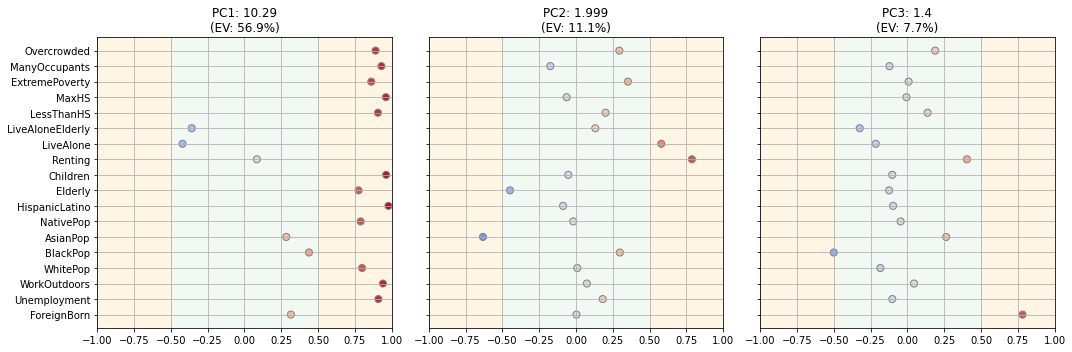

In [94]:
fig,[ax1,ax2,ax3] = plt.subplots(1,3, figsize=(15,5), sharey=True, tight_layout=True)
ax1.grid()
ax1.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax1.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax1.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax1.scatter(loadings.PC1, loadings.index, c=loadings.PC1, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax1.set_title('PC1: ' + str(round(pca_3.explained_variance_[0],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[0]*100,1)) + '%)')
ax1.set_xlim([-1,1])

ax2.grid()
ax2.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax2.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax2.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax2.scatter(loadings.PC2, loadings.index, c=loadings.PC2, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax2.set_title('PC2: ' + str(round(pca_3.explained_variance_[1],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[1]*100,1)) + '%)')
ax2.set_xlim([-1,1])

ax3.grid()
ax3.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax3.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax3.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax3.scatter(loadings.PC3, loadings.index, c=loadings.PC3, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax3.set_title('PC3: ' + str(round(pca_3.explained_variance_[2],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[2]*100,1)) + '%)')
ax3.set_xlim([-1,1])
plt.show()

PC1: represents living conditions, education level, employment status / occupation
PC2: living conditions, isolation 
PC3: race (positive for foreignborn, negative for black pop ?)

In [95]:
gdf = gpd.GeoDataFrame(scores, geometry=scores.geometry).set_index("ZIPCODE")
gdf.loc[:,'PC1_z'] = scale(gdf['PC1'])
gdf.loc[:,'PC2_z'] = scale(gdf['PC2'])
gdf.loc[:,'PC3_z'] = scale(gdf['PC3'])
gdf.head()

,PC1,PC2,PC3,TotalPop,geometry,PC1_z,PC2_z,PC3_z
ZIPCODE,,,,,,,,
90001,4.587758,1.274060,0.674626,57652,"POLYGON ((-118.24338 33.98924, -118.24333 33.9...",1.433069,0.902831,0.571291
90002,4.298106,1.372811,-0.475797,53108,"POLYGON ((-118.23431 33.96101, -118.23425 33.9...",1.342591,0.972809,-0.402917
90003,7.111192,2.365646,-0.369276,75024,"POLYGON ((-118.28285 33.97597, -118.28285 33.9...",2.221309,1.676357,-0.312712
90004,3.629253,0.936008,1.360318,58833,"POLYGON ((-118.28410 34.08349, -118.28425 34.0...",1.133663,0.663279,1.151953
90005,0.983429,1.611930,2.144050,37754,"MULTIPOLYGON (((-118.33541 34.06179, -118.3350...",0.307192,1.142255,1.815638


In [96]:
# get sensitivity scores!!
gdf['sen'] = gdf['PC1_z']*eig[0]/eig.sum() + gdf['PC2_z']*eig[1]/eig.sum() + gdf['PC3_z']*eig[2]/eig.sum()
gdf

C:\Users\scarl\AppData\Local\Temp\ipykernel_16388\650226921.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gdf['sen'] = gdf['PC1_z']*eig[0]/eig.sum() + gdf['PC2_z']*eig[1]/eig.sum() + gdf['PC3_z']*eig[2]/eig.sum()


,PC1,PC2,PC3,TotalPop,geometry,PC1_z,PC2_z,PC3_z,sen
ZIPCODE,,,,,,,,,
90001,4.587758,1.274060,0.674626,57652,"POLYGON ((-118.24338 33.98924, -118.24333 33.9...",1.433069,0.902831,0.571291,1.267485
90002,4.298106,1.372811,-0.475797,53108,"POLYGON ((-118.23431 33.96101, -118.23425 33.9...",1.342591,0.972809,-0.402917,1.110059
90003,7.111192,2.365646,-0.369276,75024,"POLYGON ((-118.28285 33.97597, -118.28285 33.9...",2.221309,1.676357,-0.312712,1.882547
90004,3.629253,0.936008,1.360318,58833,"POLYGON ((-118.28410 34.08349, -118.28425 34.0...",1.133663,0.663279,1.151953,1.066830
90005,0.983429,1.611930,2.144050,37754,"MULTIPOLYGON (((-118.33541 34.06179, -118.3350...",0.307192,1.142255,1.815638,0.583436
...,...,...,...,...,...,...,...,...,...
91790,1.319109,-1.638359,-0.038011,44855,"POLYGON ((-117.94085 34.09248, -117.93997 34.0...",0.412048,-1.160983,-0.032189,0.136860
91791,-0.075344,-1.501905,-0.044415,33902,"POLYGON ((-117.91660 34.08645, -117.91660 34.0...",-0.023535,-1.064288,-0.037612,-0.176985
91792,-0.685830,-1.439755,0.986228,31208,"POLYGON ((-117.89061 34.00858, -117.89061 34.0...",-0.214231,-1.020247,0.835164,-0.224629


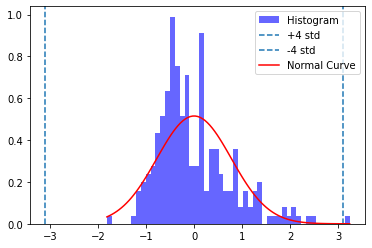

3.0963029403306677


In [78]:
mean = gdf['sen'].mean()
std = gdf['sen'].std()

x = np.linspace(gdf['sen'].min(), gdf['sen'].max(), 100) # create array of x-values for normal curve
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2) # calculate y-values for normal distribution

plt.hist(gdf['sen'], bins=50, density=True, alpha=0.6, color='blue', label='Histogram') # create the histogram
plt.axvline(mean + 4*std, linestyle='--', label='+4 std')
plt.axvline(mean - 4*std, linestyle='--', label='-4 std')
plt.plot(x, y, color='red', label='Normal Curve') # plot the normal curve
plt.legend()
plt.show()

print(mean + 4*std)

In [118]:
gdf[gdf['sen'] > mean + 4*std]


,PC1,PC2,PC3,TotalPop,geometry,PC1_z,PC2_z,PC3_z,sen
ZIPCODE,,,,,,,,,
90011,12.179985,3.160443,0.580713,106042,"POLYGON ((-118.24348 34.00247, -118.24351 34.0...",3.804637,2.239571,0.491763,3.237223


In [129]:
# gdf.drop(gdf[gdf['sen'] > mean + 4*std], axis=1)
gdf = gdf.drop(['90011'], axis=0)
gdf

,PC1,PC2,PC3,TotalPop,geometry,PC1_z,PC2_z,PC3_z,sen
ZIPCODE,,,,,,,,,
90001,4.587758,1.274060,0.674626,57652,"POLYGON ((-118.24338 33.98924, -118.24333 33.9...",1.433069,0.902831,0.571291,1.267485
90002,4.298106,1.372811,-0.475797,53108,"POLYGON ((-118.23431 33.96101, -118.23425 33.9...",1.342591,0.972809,-0.402917,1.110059
90003,7.111192,2.365646,-0.369276,75024,"POLYGON ((-118.28285 33.97597, -118.28285 33.9...",2.221309,1.676357,-0.312712,1.882547
90004,3.629253,0.936008,1.360318,58833,"POLYGON ((-118.28410 34.08349, -118.28425 34.0...",1.133663,0.663279,1.151953,1.066830
90005,0.983429,1.611930,2.144050,37754,"MULTIPOLYGON (((-118.33541 34.06179, -118.3350...",0.307192,1.142255,1.815638,0.583436
...,...,...,...,...,...,...,...,...,...
91790,1.319109,-1.638359,-0.038011,44855,"POLYGON ((-117.94085 34.09248, -117.93997 34.0...",0.412048,-1.160983,-0.032189,0.136860
91791,-0.075344,-1.501905,-0.044415,33902,"POLYGON ((-117.91660 34.08645, -117.91660 34.0...",-0.023535,-1.064288,-0.037612,-0.176985
91792,-0.685830,-1.439755,0.986228,31208,"POLYGON ((-117.89061 34.00858, -117.89061 34.0...",-0.214231,-1.020247,0.835164,-0.224629


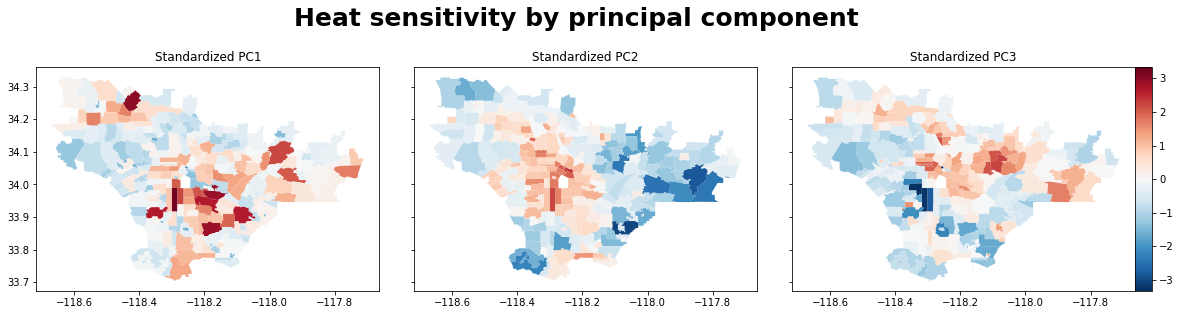

In [134]:
# plot standardized pcs
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.05]})

vmin_z = min(gdf[['PC1_z','PC2_z','PC3_z']].min()) # redefine min and max values for _z variables
vmax_z = max(gdf[['PC1_z','PC2_z','PC3_z']].max())
abs_vmax_z = max(abs(vmin_z), abs(vmax_z)) # find absolute max to center colorbar on 0
vmin_z = -abs_vmax_z*0.8 # note the *0.8 to shorten the color range slightly (otherwise map is very white)
vmax_z = abs_vmax_z*0.8

gdf.plot(column='PC1_z', cmap='RdBu_r', ax=ax[0], vmin=vmin_z, vmax=vmax_z)
ax[0].set_title('Standardized PC1')
gdf.plot(column='PC2_z', cmap='RdBu_r', ax=ax[1], vmin=vmin_z, vmax=vmax_z)
ax[1].set_title('Standardized PC2')
gdf.plot(column='PC3_z', cmap='RdBu_r', ax=ax[2], vmin=vmin_z, vmax=vmax_z)
ax[2].set_title('Standardized PC3')

divider = make_axes_locatable(ax[2]) # create a common colorbar
cax = divider.append_axes("right", size="5%", pad=0)

# add colorbar to the right side of the third subplot
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=vmin_z, vmax=vmax_z))
fig.colorbar(sm, cax=cax)

plt.suptitle('Heat sensitivity by principal component', fontsize=25, fontweight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0.1) # adjust spacing between subplots
plt.show()

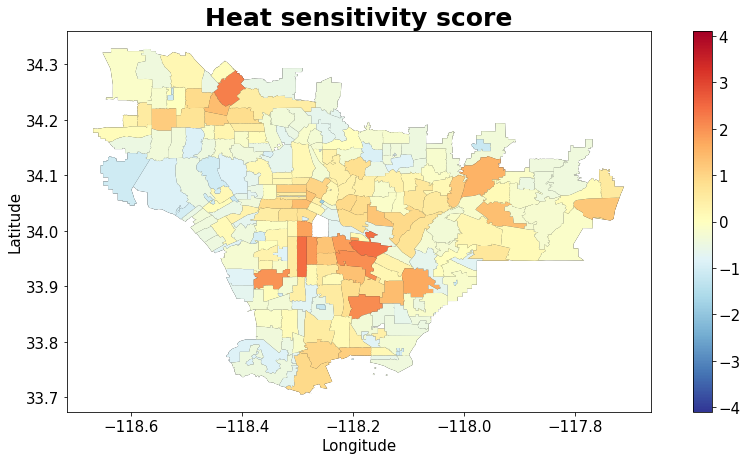

In [136]:
fig, ax = plt.subplots(figsize=(15,7))
plt.rcParams.update({'font.size': 15})
vmax = min(gdf.PC3.max(), -gdf.PC3.min()) # define vmax and vmin
vmin = -vmax

gdf.plot(ax=ax, facecolor='k', edgecolor='None')
gdf.plot(column='sen', cmap='RdYlBu_r', legend=True, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title('Heat sensitivity score', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()